In [1]:
import os
import pandas as pd
import numpy as np
import sys
# sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
sys.path.append('C:/Users/murbanek/CUSP/DOT/Bus-Capstone')
import ttools #homemade module
import gtfs #homemade module
# os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
os.chdir('C:/Users/murbanek/CUSP/DOT')
%matplotlib inline

## 1. Get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [2]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('1203_cleaned.csv')
bustime.drop('Unnamed: 0',axis=1,inplace=True)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')

bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
tripDateLookup = "2015-12-03"
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


C:\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Show range and check for extreme values of distance

(-35705.919999999998, 63991.839999999997)


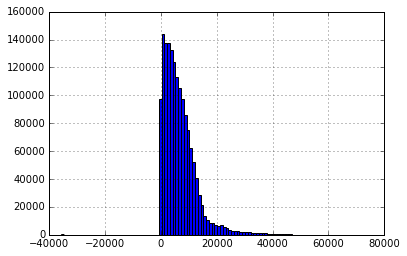

In [6]:
print (bustime['veh_dist_along_trip'].min(),bustime['veh_dist_along_trip'].max())
bustime['veh_dist_along_trip'].hist(bins=100)

## 2. calculate speed and duration between each reported location, based on distance fields.

In [7]:
bg = bustime.groupby(level=(0,1,2,3))
bustime['seg_duration'] = bg['timestamp'].diff()/ttools.datetime.timedelta(seconds=1)
bustime['seg_speed'] = bg['veh_dist_along_trip'].diff()/(bg['timestamp'].diff()/ttools.datetime.timedelta(seconds=1))

## 3. Label interruptions
Currently defined as any ping that comes after average speed of less than 0.4<p>
index_interrupts() function iterates through each ping and checks if the average speed was below threshold and if the bus is approaching or at a stop.<p>
It also labels the type of interruption.
<b>Warning: this function is not optimized for speed.  Takes several minutes on one days' data.</b>

In [8]:
def index_interrupts(df, thresh=0.4):
    counter = 0
    interruption = False
    prev_cat = ''
    prev_stop = ''
    for index, row in df.iterrows():
        if row.seg_speed > thresh:
            interruption = False
            # reset the category
            prev_cat = ''
            prev_stop = ''
        else:
            if interruption is False: # if ot was set to false in the last row, it's a new interruption
                counter += 1
            # reasons it could be True but still need a new index
            elif (row.presentable_dist=='at stop' and prev_cat == 'stop' and row.next_stop_id == prev_stop):
                pass
            elif (row.presentable_dist!='at stop' and prev_cat == 'not stop'):
                pass
            else:
                # new interruption: still slow, but new stop phase
                counter += 1
            # remember the category
            if row.presentable_dist == 'at stop':
                prev_cat = 'stop'
                prev_stop = row.next_stop_id
            else:
                prev_cat = 'not stop'
                prev_stop = ''
            interruption = True
            df.loc[index,'interruption_index'] = counter
            df.loc[index,'interruption_type'] = prev_cat
    return df

In [11]:
# need to set default index as 0, since groupby() cannot be used with indexes containing np.nan
bustime['interruption_index'] = 0
bustime['interruption_type'] = ''

In [12]:
bustime_interru = bg.apply(index_interrupts)

Show ALL the data from a trip that contained some negative speed.  We want to see how the index_interrupts function worked on that trip's data

In [13]:
i_tups = []
for i,v in bustime_interru.query('seg_speed < -1').iterrows():
    i_tups.append(i[:4])
# display the first example
bustime_interru.xs(i_tups[0],level=(0,1,2,3))

,lat,lon,timestamp,shape_id,next_stop_id,dist_from_stop,stop_dist_on_trip,presentable_dist,veh_dist_along_trip,seg_duration,seg_speed,interruption_index,interruption_type
timestamp,,,,,,,,,,,,,
2015-12-03T01:35:01.805-05:00,40.580227,-73.967634,01:35:01,B1O0243,300018,0.00,3007.67,at stop,3007.67,NaN,NaN,1,stop
2015-12-03T01:36:05.669-05:00,40.580467,-73.967579,01:36:05,B1O0243,300019,108.40,3143.17,approaching,3034.77,64,0.423437,0,
2015-12-03T01:37:07.970-05:00,40.580467,-73.967579,01:37:07,B1O0243,300019,108.40,3143.17,approaching,3034.77,62,0.000000,2,not stop
2015-12-03T01:37:39.147-05:00,40.580467,-73.967579,01:37:39,B1O0243,300019,108.40,3143.17,approaching,3034.77,32,0.000000,2,not stop
2015-12-03T01:38:41.533-05:00,40.580467,-73.967579,01:38:41,B1O0243,300019,108.40,3143.17,approaching,3034.77,62,0.000000,2,not stop
2015-12-03T01:39:12.692-05:00,40.580515,-73.967567,01:39:12,B1O0243,300019,102.98,3143.17,approaching,3040.19,31,0.174839,2,not stop
2015-12-03T01:40:15.013-05:00,40.580515,-73.967567,01:40:15,B1O0243,300019,102.98,3143.17,approaching,3040.19,63,0.000000,2,not stop
2015-12-03T01:43:54.347-05:00,40.577289,-73.953935,01:43:54,B1O0243,300009,45.93,1323.06,approaching,1277.13,219,-8.050502,2,not stop
2015-12-03T01:44:25.917-05:00,40.577699,-73.955840,01:44:25,B1O0243,300010,53.21,1505.48,approaching,1452.27,31,5.649677,0,


## 4. Summarize the interruptions
Summarization contains the timestamp range based on the LAST ping before the interruption of the last ping labeled as interruption.

In [14]:
bustime_interru.set_index('interruption_index',append=True,inplace=True)
bustime_interru = bustime_interru.swaplevel(4,5)
# for each vehicle, align previous timestamp/distance from the previous ping
prev_rows = bustime_interru.groupby(level=(0,1,2,3)).shift(1)[['timestamp','veh_dist_along_trip']]
# then take the earlier of the previous pings and latest of the interruption pings
begins = prev_rows.groupby(level=(0,1,2,3,4)).min()
ends = bustime_interru.groupby(level=(0,1,2,3,4))[['timestamp','veh_dist_along_trip']].max()

In [15]:
begins.join(ends,lsuffix='_begin',rsuffix='_end')

timestamp_begin  \
route       trip_id                             trip_date  vehicle_id    interruption_index                    
MTA NYCT_B1 FB_D5-Weekday-SDon-047200_B49_15    2015-12-03 MTA NYCT_5125 0                          07:59:24   
                                                                         1                               NaT   
            FB_D5-Weekday-SDon-051000_B49_15    2015-12-03 MTA NYCT_4855 1                               NaT   
                                                           MTA NYCT_5125 0                          08:37:55   
                                                                         1                               NaT   
                                                                         2                          08:58:01   
                                                           MTA NYCT_7146 0                          08:33:58   
                                                                         1                               NaT   
            FB_D5-Weekday-SDon-051200_B49_21    2015-12-03 MTA NYCT_7146 0                          08:52:28   
                                                                         1                          08:51:25   
            UP_D5-Weekday-SDon-006000_B1_1      2015-12-03 MTA NYCT_4877 0                          00:59:31   
                                                                         1                          00:57:25   
                                                                         2                          01:13:41   
                                                                         3                          01:19:57   
                                                                         4                          01:31:59   
            UP_D5-Weekday-SDon-009800_B1_1      2015-12-03 MTA NYCT_4877 0                          01:36:10   
                                                                         1                          01:33:33   
                                                                         2                          01:45:39   
                                                                         3                          01:51:26   
                                                                         4                          01:54:34   
                                                                         5                          02:12:58   
            UP_D5-Weekday-SDon-010000_B1_2      2015-12-03 MTA NYCT_4893 0                          01:35:01   
                                                                         1                               NaT   
                                                                         2                          01:36:05   
                                                                         3                          01:44:25   
                                                                         4                          01:49:39   
                                                                         5                          02:14:25   
            UP_D5-Weekday-SDon-013800_B1_2      2015-12-03 MTA NYCT_4893 0                          02:21:15   
                                                                         1                               NaT   
                                                                         2                          02:27:02   
...                                                                                                      ...   
MTABC_QM8   9867152-CPPD5-CP_D5-Weekday-10-SDon 2015-12-03 MTABC_3472    2                          19:16:13   
            9867153-CPPD5-CP_D5-Weekday-10-SDon 2015-12-03 MTABC_3166    0                          05:58:15   
                                                                         1                               NaT   
                                                             